In [5]:
import pandas as pd
import numpy as np
import math
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Input Data
#### real - index: date, columns: real price of each ticker
#### pred - index: date, columns: pred price of each ticker

In [16]:
# Data loading and pre-processing
real = pd.read_csv("../outputs/predicted_price_lstm_model_with_price.csv", index_col = "date")
pred = pd.read_csv("../outputs/actual_price_lstm_model_with_price.csv", index_col = "date")
# real.index = pd.to_datetime(real.index)
# pred.index = pd.to_datetime(pred.index)

# real dataset
real.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,80.336105,393.00067,116.34463,179.23355,209.82968,100.544100,280.68417,103.381676,64.119210,54.443584,...,162.06331,130.19400,172.78558,214.14462,245.35655,48.609238,199.38200,66.138070,90.994680,92.182940
2020-02-19,78.458810,393.26530,116.84297,178.10449,208.57920,101.153496,273.48462,102.736060,62.890940,55.987015,...,179.04692,129.13193,172.51245,214.69136,248.47482,48.055300,202.08955,67.006970,90.007030,96.137820
2020-02-20,79.852330,400.64640,121.61205,178.98994,211.20715,100.654060,280.08313,103.298830,64.484660,58.009445,...,189.33052,131.46819,168.77423,215.13790,251.50127,48.104416,201.17467,66.776794,91.147390,102.473170
2020-02-21,78.793330,391.93665,122.77984,178.52678,208.36505,99.690390,274.98750,103.055690,63.871647,56.629665,...,187.13387,129.16390,168.65090,213.19860,249.80310,47.926100,193.35634,66.642715,90.599540,105.205190
2020-02-24,76.847080,378.16388,121.35294,176.32437,203.34367,98.962320,263.37717,103.406685,62.178200,52.902378,...,185.25813,126.39526,167.88463,209.93954,249.67513,47.606710,184.90543,66.740425,88.485855,103.109634


In [17]:
# real dataset
pred.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,79.137695,378.85,115.594800,174.49327,207.06,100.81135,269.93,102.16,64.390090,56.89,...,171.680,127.588356,170.17220,210.48,245.93,49.602440,199.380,68.79209,88.263490,96.39
2020-02-19,80.283830,383.28,120.781310,175.77339,210.76,100.00934,277.15,103.21,66.613500,58.90,...,183.484,129.425770,168.36691,211.23,247.78,49.803300,197.580,68.43440,89.717410,103.93
2020-02-20,79.460205,378.96,121.424750,175.30789,206.67,98.92712,272.49,102.54,65.615440,57.27,...,179.882,127.811960,168.01974,209.06,245.10,49.612003,190.560,68.31840,88.807470,105.29
2020-02-21,77.661620,372.95,119.679665,173.18407,201.91,98.27971,260.26,103.14,63.510605,53.28,...,180.200,124.944040,167.32541,206.12,246.29,49.210285,183.860,68.46340,86.760124,101.76
2020-02-24,73.972664,357.41,114.415160,169.26614,194.37,96.66603,240.11,99.02,60.358295,49.12,...,166.758,118.061030,166.22440,200.41,237.01,46.895634,177.105,68.02838,84.247920,105.01


In [142]:
# global parameters
short_tol = -0.001
long_num = 3
balance = 100000.0
pct = 1
long_only = False

pred_r = pred.pct_change()
total_days = real.shape[0] - 1

In [143]:
def DivideLongShort(total, pct):
    long_budget = total * pct
    short_margin = total - long_budget
    return long_budget, short_margin

def OrderBook(budget, candidates, costs, long=True):
#     print(candidates)
    if len(candidates) == 0:
        return {}
    orders = {ticker:0 for ticker in candidates}
    order_cost = 0
    ticker_budget = float(budget)/len(candidates)
    
    for i in range(len(candidates)):
        ticker = candidates[i]
        cost = costs[i]
        if long:
            orders[ticker] = int(ticker_budget/cost)
        else:
            orders[ticker] = int(ticker_budget/cost) * -1
        order_cost += orders[ticker] * cost
    
    return orders, order_cost

def UpdateBalance(prev_balance, long_orders, long_cost, short_orders, short_cost, real_prices):
    cur_balance = prev_balance - long_cost - short_cost
    for ticker in long_orders:
        cur_balance += long_orders[ticker] * real_prices[ticker]
    try:
        for ticker in short_orders:
            cur_balance += short_orders[ticker] * real_prices[ticker]
    except: pass
    return cur_balance

def DailyTrade(beg_balance, day, long_only=False):
    
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

#     short_tickers = daily_data[daily_data['pred_r'] <= short_tol]['ticker'].tolist()
#     short_costs = daily_data[daily_data['pred_r'] <= short_tol]['cost'].tolist()
    long_tickers = daily_data.tail(long_num)['ticker'].tolist()
    long_costs = daily_data.tail(long_num)['cost'].tolist()
    short_tickers = daily_data.head(long_num)['ticker'].tolist()
    short_costs = daily_data.head(long_num)['cost'].tolist()
    
    if not long_only:

        long_budget, short_margin = DivideLongShort(beg_balance, pct)
        long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
        short_orders, short_order_cost = OrderBook(short_margin, short_tickers, short_costs, False)
        real_prices = real.iloc[day + 1]

        cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                    short_orders, short_order_cost, real_prices)
    else:
        long_budget = beg_balance
        long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
        real_prices = real.iloc[day + 1]
        cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                    {}, 0, real_prices)
    
    return cur_balance, long_orders

def DailyBenchmark(beg_balance, day):
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    long_tickers = daily_data['ticker'].tolist()
    long_costs = daily_data['cost'].tolist()
    long_orders, long_order_cost = OrderBook(beg_balance, long_tickers, long_costs)
    real_prices = real.iloc[day + 1]

    cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, {}, 0, real_prices)
    
    return cur_balance

In [144]:
tradebal = copy.copy(balance)
bmbal = copy.copy(balance)
benchmark = []
my_portfolio = []
portfolio_book = []

for day in range(total_days):
    tradebal, long_stocks_day = DailyTrade(tradebal, day, long_only)
    portfolio_book.append(long_stocks_day)
    my_portfolio.append(tradebal)
    bmbal = DailyBenchmark(bmbal, day)
    benchmark.append(bmbal)
    
r_my = []
for x, y in zip(my_portfolio[:-1], my_portfolio[1:]):
    r_my.append((y - x) / x)
    
r_bm = []
for x, y in zip(benchmark[:-1], benchmark[1:]):
    r_bm.append((y - x) / x)
    
r_my = np.array(r_my)
r_bm = np.array(r_bm)
ir = (r_my.mean() - r_bm.mean()) / (r_my - r_bm).std() * np.sqrt(252)
sharpe = (r_my.mean()) / (r_my).std() * np.sqrt(252)

print('Benchmark final: ', bmbal)
print('My Portfolio final: ', tradebal)
print('Information Ratio: ', ir)
print('Sharpe Ratio: ', sharpe)

Benchmark final:  152135.975455201
My Portfolio final:  402147.0019283004
Information Ratio:  2.192414998505649
Sharpe Ratio:  2.479541796926051


In [151]:
402147.0019283004 / 152135.975455201 - 1

1.643339293845849

In [145]:
portfolio_book = [{}] + portfolio_book

In [146]:
port_df = pd.DataFrame.from_dict(portfolio_book).fillna(0).set_index(real.index)

In [147]:
order_df = port_df.diff().shift(-1).fillna(0)

In [148]:
num_long_order = order_df.clip(lower=0).sum(axis=1)
num_short_order = order_df.clip(upper=0).sum(axis=1)

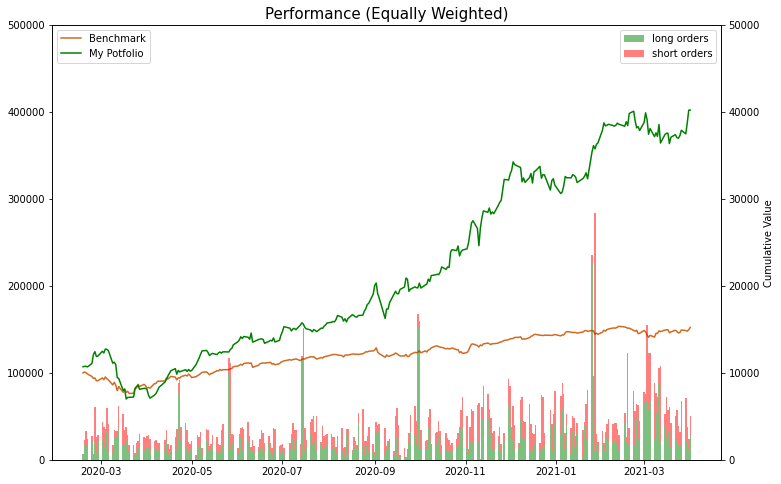

In [149]:
x = pd.to_datetime(real.index)[:-1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)  
ax.plot(x, benchmark, '-', color="chocolate", label='Benchmark')
ax.plot(x, my_portfolio, '-', color="green", label='My Potfolio')
ax.set_ylim(0, 500000)

ax2 = ax.twinx()
ax2.bar(x, num_long_order.values[:-1], width=1, color="green", alpha=0.5, label="long orders")
ax2.bar(x, num_short_order.abs().values[:-1], bottom=num_long_order.values[:-1], width=1, color="red", alpha=0.5, label="short orders")
ax2.set_ylim(0, 50000)

# set xticks
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# fmt_day = mdates.DayLocator()
# ax.xaxis.set_minor_locator(fmt_day)
# fig.autofmt_xdate()

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Performance (Equally Weighted)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.savefig("./portfolio_performance.png")
plt.show()